# Eyes Classifier Model Training

## Importing Necessary Libraries

In this section, we import essential libraries required for building and training a deep learning model using TensorFlow and Keras. Below is a breakdown of the imported modules:

- **TensorFlow & Keras**: Used for constructing and training neural networks.
- **Matplotlib**: Helps visualize data and model performance.
- **Keras Backend**: Provides low-level functionalities such as tensor operations.
- **ImageDataGenerator**: Facilitates data augmentation for training images.
- **Image Processing Utilities**: Includes functions for loading and preprocessing images.
- **OS**: Used for handling file paths and directories.
- **NumPy & Pandas**: Essential for numerical computations and data manipulation.
- **re (Regular Expressions)**: Helps in pattern matching and text processing.


In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
import re

## Image Count Bar Chart

### Counting Images in a Dataset Structure

This function, `count_images_in_dataset(dataset_path)`, counts the number of images in each class folder within the `train`, `val`, and `test` directories of a dataset. 

#### Function Breakdown:
- **Inputs:**  
  - `dataset_path` (str): Path to the dataset directory.  
- **Process:**  
  - Iterates through three main subdirectories: `train`, `val`, and `test`.  
  - Inside each subdirectory, iterates through class folders.  
  - Counts image files (`.png`, `.jpg`, `.jpeg`, `.gif`, `.bmp`, `.webp`) in each class folder.  
  - Stores results in a list of dictionaries.  
- **Output:**  
  - A Pandas DataFrame with three columns:  
    - `Split`: Indicates whether the images belong to `train`, `val`, or `test`.  
    - `Class`: Name of the class folder.  
    - `Image Count`: Number of images in that class folder.  

This function provides an overview of image distribution across different dataset splits, helping in dataset analysis and model training evaluation.


In [2]:
def count_images_in_dataset(dataset_path):
    dataset_summary = []

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(dataset_path, split)
        if os.path.isdir(split_path):
            for class_folder in os.listdir(split_path):
                class_path = os.path.join(split_path, class_folder)
                if os.path.isdir(class_path):
                    image_count = sum(1 for file in os.listdir(class_path) 
                                      if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp', 'webp')))
                    dataset_summary.append({'Split': split, 'Class': class_folder, 'Image Count': image_count})

    return pd.DataFrame(dataset_summary)


### Generates a bar chart displaying the number of images in each subfolder.

In [3]:
def plot_image_counts(dataset_path):
    df = count_images_in_dataset(dataset_path)
    
    plt.figure(figsize=(12, 6))
    
    # Create bar plot
    for split in df['Split'].unique():
        subset = df[df['Split'] == split]
        plt.bar(subset['Class'], subset['Image Count'], label=split, alpha=0.7)

    plt.xlabel('Plant Type')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Plant Type (Train, Val, Test)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Dataset Split")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()


### Example usage

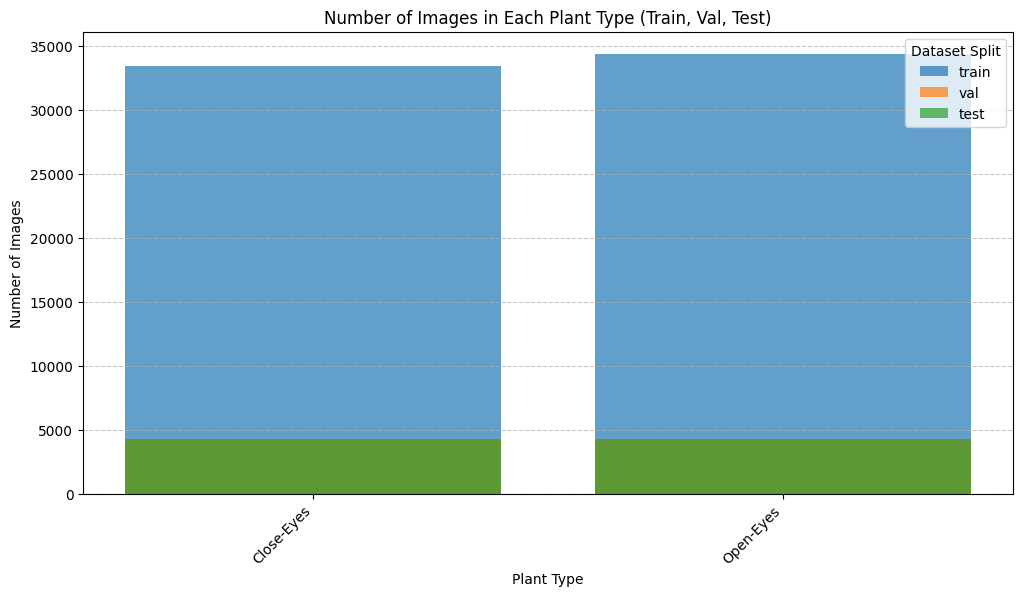

In [4]:
dataset_path = "./../MRL_DataSet/data"
plot_image_counts(dataset_path)

## Set all the Constants

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
CHANNELS=3
EPOCHS = 10

## Initializing, Exploring & Partioning the Dataset

#### Function to Convert Grayscale to RGB

In [6]:
def convert_to_rgb(image):
    if image.shape[-1] == 1:  # Check if it's grayscale
        image = tf.image.grayscale_to_rgb(image)  # Convert to RGB
    return image

#### Custom preprocessing function to apply grayscale-to-RGB conversion

In [7]:
def preprocess_image(img):
    img = convert_to_rgb(img)
    return img

## Data Augmentation for Training Images

#### `ImageDataGenerator` for Training Data
The `ImageDataGenerator` class is used to apply real-time data augmentation techniques to training images, improving model generalization.

#### **Augmentation Techniques Applied:**
- **`rescale=1./255`**: Normalizes pixel values to the range `[0, 1]`, improving numerical stability for training.  
- **`rotation_range=30`**: Randomly rotates images up to 30 degrees.  
- **`width_shift_range=0.2`**: Shifts images horizontally by up to 20% of the width.  
- **`height_shift_range=0.2`**: Shifts images vertically by up to 20% of the height.  
- **`shear_range=0.2`**: Applies shear transformations to distort images slightly.  
- **`zoom_range=0.2`**: Randomly zooms in or out by up to 20%.  
- **`horizontal_flip=True`**: Flips images horizontally to increase variety.  
- **`fill_mode='nearest'`**: Fills missing pixels with the nearest neighboring pixel value after transformations.
- **`preprocessing_function=preprocess_image`**: Preprocessing function to apply grayscale-to-RGB conversion.

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,        
    rotation_range=30,   
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0.2,     
    zoom_range=0.2, 
    horizontal_flip=True,   
    fill_mode='nearest',     
    preprocessing_function=preprocess_image
)

### **Creating the Training Data Generator**

In [9]:
train_generator = train_datagen.flow_from_directory(
        "./../MRL_DataSet/data/train",
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse",
)

Found 67774 images belonging to 2 classes.


### Checking the Available Classes

In [10]:
class_names = list(train_generator.class_indices.keys())
N_CLASSES = len(class_names)
class_names

['Close-Eyes', 'Open-Eyes']

### Displaying Some Sample Images

In [11]:
# plt.figure(figsize=(20, 10))
# for image_batch,label_batch in train_generator.take(1):
#     for i in range(15):
#         ax = plt.subplot(3,5,i+1)
#         plt.imshow(image_batch[i].numpy().astype( "uint8" ))
#         plt.title( class_names[ label_batch[i] ] )
#         plt.axis( "off")

### Checking Batch Size

In [12]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


## Validation Data Preprocessing

In this section, we set up the preprocessing for the validation dataset. Similar to the training dataset, we apply data normalization and mild augmentations.

In [13]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        "./../MRL_DataSet/data/val",
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse"
)

Found 8580 images belonging to 2 classes.


## Test Data Preprocessing

In this section, we set up the preprocessing for the test dataset. Similar to the validation dataset, we apply data normalization and mild augmentations.

In [14]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        "./../MRL_DataSet/data/test",
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse"
)

Found 8544 images belonging to 2 classes.


## Building the Model

### Checking what is the expected dimension order for channel

In [15]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [16]:
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_CLASSES, activation='softmax'),
])

### Model Summary

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

### Compiling the Model
We use **adam** Optimizer, **SparseCategoricalCrossentropy** for losses, **accuracy** as a metric

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Training the Network

In [19]:
steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE)
validation_steps = max(1, validation_generator.samples // BATCH_SIZE)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    batch_size=BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
2117/2117 [==============================] - 927s 435ms/step - loss: 0.1686 - accuracy: 0.9360 - val_loss: 0.2818 - val_accuracy: 0.9042
Epoch 2/10
2117/2117 [==============================] - 891s 421ms/step - loss: 0.0816 - accuracy: 0.9720 - val_loss: 0.2300 - val_accuracy: 0.8942
Epoch 3/10
2117/2117 [==============================] - 859s 406ms/step - loss: 0.0656 - accuracy: 0.9767 - val_loss: 0.2618 - val_accuracy: 0.8862
Epoch 4/10
2117/2117 [==============================] - 874s 413ms/step - loss: 0.0586 - accuracy: 0.9797 - val_loss: 0.1785 - val_accuracy: 0.9249
Epoch 5/10
2117/2117 [==============================] - 857s 405ms/step - loss: 0.0535 - accuracy: 0.9812 - val_loss: 0.1419 - val_accuracy: 0.9471
Epoch 6/10
2117/2117 [==============================] - 806s 381ms/step - loss: 0.0484 - accuracy: 0.9828 - val_loss: 0.1851 - val_accuracy: 0.9241
Epoch 7/10
2117/2117 [==============================] - 813s 384ms/step - loss: 0.0455 - accuracy: 0.9841 - val_

### Testing the Model

In [25]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_generator)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
267/267 [==============================] - 89s 334ms/step - loss: 0.0906 - accuracy: 0.9657
Test Accuracy: 96.57%


### Plotting the Accuracy and Loss Curves

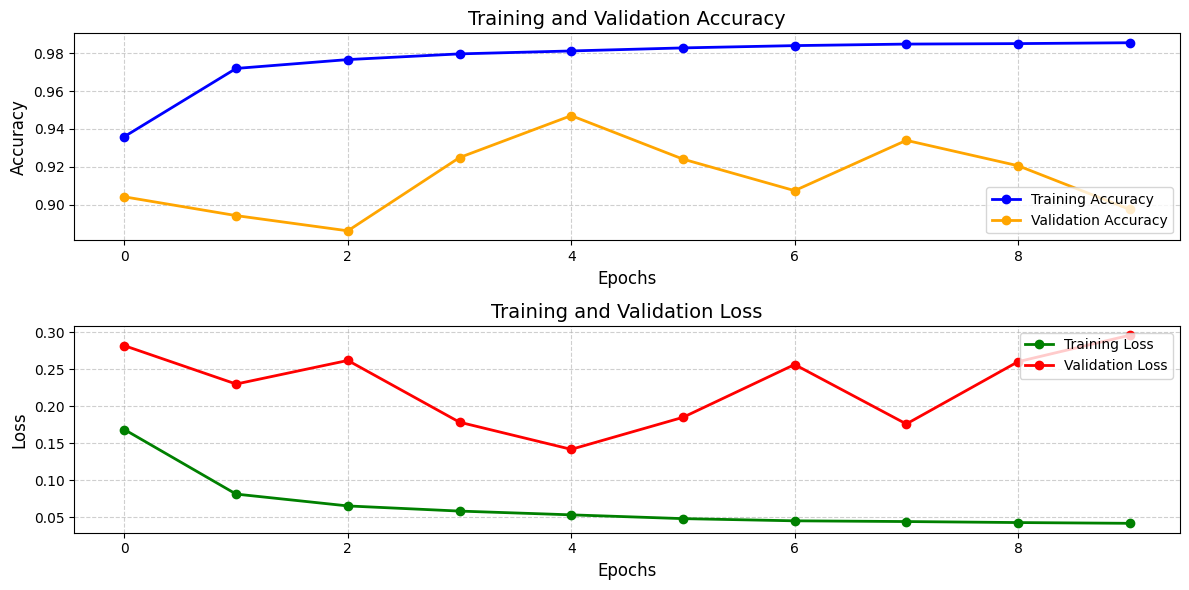

In [21]:
# Define data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

# Create a figure with improved layout and separate plots for better readability
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(2, 1, 1)  # 2 rows, 1 column, position 1
plt.plot(epochs_range, acc, 'o-', label='Training Accuracy', color='blue', linewidth=2)
plt.plot(epochs_range, val_acc, 'o-', label='Validation Accuracy', color='orange', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right', fontsize=10)

# Plot Training and Validation Loss
plt.subplot(2, 1, 2)  # 2 rows, 1 column, position 2
plt.plot(epochs_range, loss, 'o-', label='Training Loss', color='green', linewidth=2)
plt.plot(epochs_range, val_loss, 'o-', label='Validation Loss', color='red', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Saving the Model
We append the model to the list of models as a new version

In [22]:
# Ensure the models directory exists
models_dir = "./models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Get the highest model version number for 'Sugarcane_Model'
existing_versions = []
pattern = re.compile(r"Eye_Model(\d+)\.h5")

for filename in os.listdir(models_dir):
    match = pattern.match(filename)
    if match:
        existing_versions.append(int(match.group(1)))

new_version = max(existing_versions, default=0) + 1

# ✅ Save the complete model (architecture + weights)
model.save(f"{models_dir}/Eye_Model{new_version}.h5")


### Function for Inference

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Plotting the Inference Data

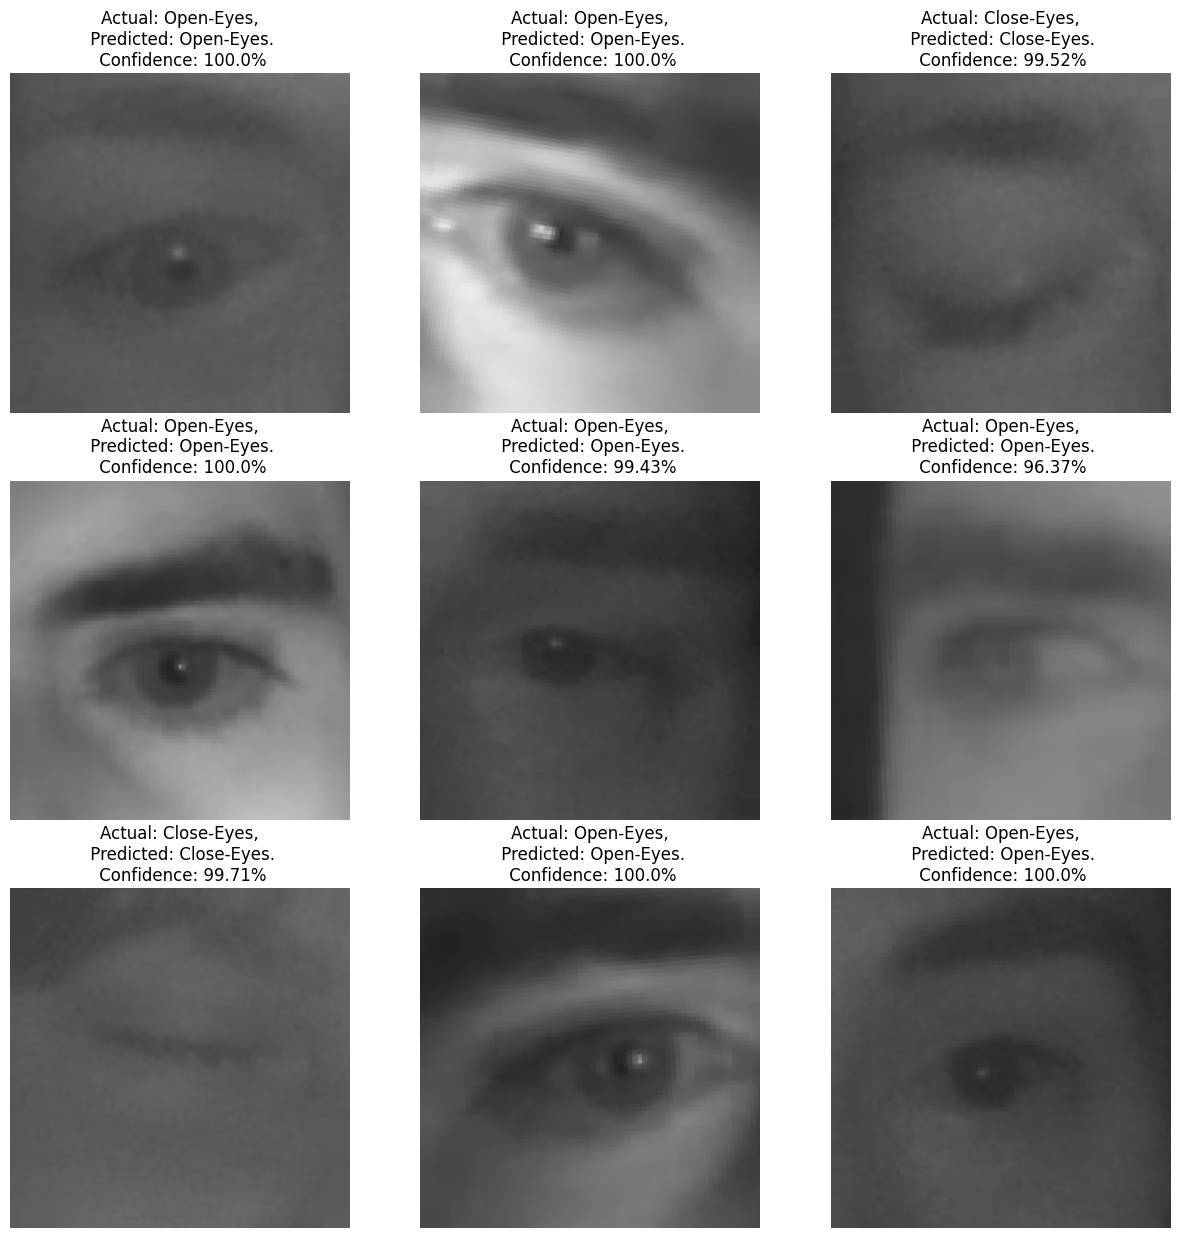

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break